In [1]:
%matplotlib inline
import numpy as np, matplotlib.pyplot as plt, IPython.display as ipd
import librosa, librosa.display
from scipy import signal
from pathlib import Path
import subprocess
import ffmpeg
from typing import Union

In [2]:
DIR = Path("../trabalho1/")
WORK_DIR = Path('.temp-res/')

In [3]:
WORK_DIR.mkdir(parents=True, exist_ok=True)

In [4]:
INPUT_VIDEO_FILENAMES = DIR / 'camera1.webm', DIR / 'camera2.webm'

In [71]:
INPUT_VIDEO_FILENAMES = WORK_DIR / 'trim1.mp4', WORK_DIR / 'trim2.mp4'

In [72]:
def prepare_media(input_media: Path, output: Path):
    """Convert audio to wave using ffmpeg"""
    
    out_video = output.with_suffix('.mp4')
    out_audio = output.with_suffix('.wav')
    
#     print(out_audio, out_video)
    
    stream = ffmpeg.input(input_media)
#     audio = stream.audio
#     video = stream.video
    
    try:
        # Block simplifies chaining
#         (
#             video
#             .filter('scale', '-1', '720')  ## Reduce to 720p
#             .filter('fps', 25)             ## Constant framerate
#             .output(out_video.as_posix(), pix_fmt='yuv420p', f='mp4')
#             .overwrite_output()
#             .run()
#         )
        a = (
            stream
            .filter('asetpts', 'N/(25*TB)')
            .output(out_audio.as_posix(), codec='pcm_s16le')
            .overwrite_output()
        )
        print(ffmpeg.compile(a))
        a.run()
        
    except Exception as e:
        print(e.stderr)
        print(e.stdout)
        raise(e)
        
    return (out_video, out_audio)


In [73]:
# FILENAMES (video, audio), (video, audio)
MEDIA_FILENAMES = [ prepare_media(filename, WORK_DIR / filename.stem ) for filename in INPUT_VIDEO_FILENAMES ]
MEDIA_FILENAMES

['ffmpeg', '-i', PosixPath('.temp-res/trim1.mp4'), '-filter_complex', '[0]asetpts=N/(25*TB)[s0]', '-map', '[s0]', '-codec', 'pcm_s16le', '.temp-res/trim1.wav', '-y']
['ffmpeg', '-i', PosixPath('.temp-res/trim2.mp4'), '-filter_complex', '[0]asetpts=N/(25*TB)[s0]', '-map', '[s0]', '-codec', 'pcm_s16le', '.temp-res/trim2.wav', '-y']


[(PosixPath('.temp-res/trim1.mp4'), PosixPath('.temp-res/trim1.wav')),
 (PosixPath('.temp-res/trim2.mp4'), PosixPath('.temp-res/trim2.wav'))]

# Find delay between files based on the audio.

In [74]:
def lag_finder(y1, y2, sr):
    """Uses cross relation to find delay between audios.
    see: https://stackoverflow.com/a/56432463/25612
    """
    n = len(y1)
    middle = n // 2 

    corr = (
        signal.correlate(y2, y1, mode='same')
            / np.sqrt(
                signal.correlate(y1, y1, mode='same')[middle]
                * signal.correlate(y2, y2, mode='same')[middle]
            )
    )

    delay_arr = np.linspace(-0.5*n/sr, 0.5*n/sr, n)
    delay = delay_arr[np.argmax(corr)]
    print('y2 is ' + str(delay) + ' behind y1')

    plt.figure()
    plt.plot(delay_arr, corr)
    plt.title('Lag: ' + str(np.round(delay, 3)) + ' s')
    plt.xlabel('Lag')
    plt.ylabel('Correlation coeff')
    plt.show()
    return delay

##  Load audio as wav files and process them

In [75]:
audios_filenames = [entry[1] for entry in MEDIA_FILENAMES]
(x_1, sr_1), (x_2, sr_2) = map(librosa.load, audios_filenames)

Sample rate is the same, as the file was created by us earlier.

In [76]:
sampling_rate = sr_1
sampling_rate

22050

Need to make the files equal. We just right zero-pad the smaller file.

In [82]:
len(x_1), len(x_2)

(479232, 511488)

In [78]:
(how_many := len(x_1) - len(x_2))

-32256

In [39]:
print(f'Before: {len(x_2)}')
x_2 = np.pad(x_2, pad_width=(0, how_many), mode='constant', constant_values=0)
print(f'After:  {len(x_2)}')

Before: 511296
After:  578560


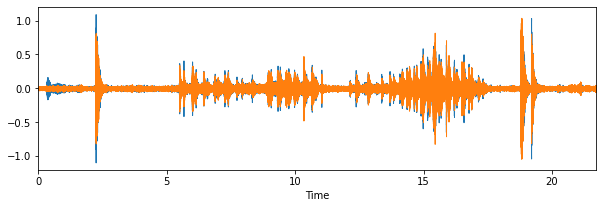

In [79]:
plt.figure(figsize=(10, 3))
librosa.display.waveplot(x_2, sampling_rate, max_points=len(x_1))
librosa.display.waveplot(x_1, sampling_rate, max_points=len(x_1))

y2 is 2.2675784277836897e-05 behind y1


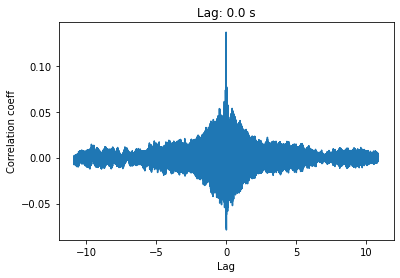

In [83]:
DELAY = lag_finder(x_1, x_2[:len(x_1)], sampling_rate)

# Sync videos by trimming
The late file must be trimmed to have the same beggining
as the early one.
Also resize video to a 720p if not already in this format

In [60]:
def scale(video):
    return (
        ffmpeg
        .input(video)
#         .setpts('N/(25*TB)')
        .filter('scale', '-1', '720')  ## Reduce to 720p
    )

In [61]:
def output(stream, path):
    outfilename = (path.parent / f'processed-{path.name}').as_posix()
    
    return (
        stream
        .filter('fps', 25)
        .output(outfilename, pix_fmt='yuv420p', f='mp4')
        .overwrite_output()
    )

In [62]:
def thumbnail(stream):
    return (
        stream
#         .filter('fps', 10)
        .filter('scale', '-1', '360')
    )

In [63]:
def side_by_side(outfilename, streams):
    return (
        ffmpeg
        .overlay(*list(map(thumbnail, streams)), y=0, x=360)
        .output(outfilename)
        .overwrite_output()
    )

In [64]:
videos_filenames = [entry[0] for entry in MEDIA_FILENAMES]
videos_filenames

[PosixPath('.temp-res/camera1.mp4'), PosixPath('.temp-res/camera2.mp4')]

In [65]:
streams = list(map(scale, INPUT_VIDEO_FILENAMES))

In [66]:
streams[0] = streams[0].trim(start=DELAY) # trim only the late file

In [67]:
streams

[trim(start=4.514588302012477)[None] <135adfcc2b1d>,
 scale('-1', '720')[None] <1a42e67a1e05>]

In [ ]:
mini = side_by_side('/Users/torres/Downloads/bob.mp4', streams)

In [ ]:
ffmpeg.compile(mini)

In [ ]:
mini.run()

In [ ]:
videos_filenames = [Path('../)]

In [68]:
out_streams = [output(stream, path) for stream, path in zip(streams, videos_filenames)]

In [69]:
ffmpeg.compile(out_streams)

['ffmpeg',
 '-i',
 PosixPath('../trabalho1/camera2.webm'),
 '-i',
 PosixPath('../trabalho1/camera1.webm'),
 '-filter_complex',
 '[0]scale=-1:720[s0];[s0]fps=25[s1];[1]scale=-1:720[s2];[s2]trim=start=4.514588302012477[s3];[s3]fps=25[s4]',
 '-map',
 '[s1]',
 '-f',
 'mp4',
 '-pix_fmt',
 'yuv420p',
 '.temp-res/processed-camera2.mp4',
 '-map',
 '[s4]',
 '-f',
 'mp4',
 '-pix_fmt',
 'yuv420p',
 '.temp-res/processed-camera1.mp4',
 '-y',
 '-y']

In [70]:
ffmpeg.merge_outputs(*out_streams).run()

(None, None)

In [ ]:
!open .